# Edge Prediction for Heterogeneous Networks

## Single Permutation Analysis with Neural Networks and Baseline Models

This notebook performs comprehensive edge prediction analysis on a single permutation of a heterogeneous network. It trains and evaluates multiple machine learning models to predict the existence of edges between nodes based on network topology features.

## Overview

This notebook implements and compares multiple machine learning approaches for predicting edges in heterogeneous biological networks. The analysis focuses on understanding which node pairs are likely to have biological relationships based on network topology features.

### Key Features

- **Flexible Edge Type Support**: Configurable for different relationship types (Anatomy-Gene, Compound-Gene, Disease-Gene, etc.)
- **Multiple Model Comparison**: Neural networks, logistic regression, polynomial features, and random forests
- **Comprehensive Evaluation**: ROC curves, precision-recall analysis, and probability heatmaps
- **Parameterized Analysis**: Support for different permutations and edge/node type combinations

### Methodology

1. **Data Loading**: Load permutation-specific heterogeneous network data with configurable edge and node types
2. **Feature Engineering**: Extract node degree features and create balanced positive/negative sample sets
3. **Model Training**: Train neural network and baseline models with cross-validation
4. **Evaluation**: Compare model performance using AUC, average precision, and visualization
5. **Analysis**: Generate probability heatmaps and comprehensive performance comparisons

### Workflow

The notebook uses a consolidated script approach (`src/run_edge_prediction.py`) that handles:
- Parameterized data loading and preprocessing
- Neural network training with early stopping
- Baseline model training (Logistic Regression, Polynomial LR, Random Forest)
- Automated visualization generation (ROC curves, training plots, probability heatmaps)
- Structured results saving and model persistence

### Output

The analysis generates:
- Trained models for all approaches
- Performance metrics and comparison reports
- Visualization plots (training history, ROC comparisons, heatmaps)
- Structured JSON results for downstream analysis

In [34]:
# Import all required libraries
import warnings
import pathlib
import sys

# Add src directory to path for helper functions
repo_dir = pathlib.Path().cwd().parent
src_dir = repo_dir / "src"
sys.path.insert(0, str(src_dir))

# Data manipulation and scientific computing
import pandas as pd
import numpy as np
import scipy.sparse

# Machine learning and neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Progress bars and utilities
from tqdm import tqdm

# Time tracking
import time

# Domain-specific libraries
import hetmatpy.matrix

# Import helper functions from src package
from models import EdgePredictionNN, get_model_info
from data_processing import (
    prepare_edge_prediction_data,
    load_permutation_data,
    load_all_permutations,
)
from training import train_edge_prediction_model, train_across_permutations
from visualization import (
    plot_training_history,
    evaluate_model_performance,
    create_probability_heatmap,
    plot_permutation_comparison,
)

In [35]:
# Parameters for papermill
# Default parameter values - can be overridden by papermill
permutations_subdirectory = "permutations"  # Default: use 'permutations' (local generated)
permutation_name = None  # Specific permutation to process (e.g., "000", "001", etc.)
output_dir = "models"  # Directory to save trained models

# Edge and node type parameters for flexible relationship modeling
edge_type = "AeG"  # Edge type to model (e.g., "AeG", "CbG", "DaG", "GiG", etc.)
source_node_type = "Anatomy"  # Source node type (e.g., "Anatomy", "Compound", "Disease", "Gene")
target_node_type = "Gene"  # Target node type (e.g., "Gene", "Anatomy", "Disease", "Compound")

# Validation
if not isinstance(permutations_subdirectory, str):
    raise ValueError(f"permutations_subdirectory must be a string, got: {permutations_subdirectory}")

if permutation_name is not None and not isinstance(permutation_name, str):
    raise ValueError(f"permutation_name must be a string or None, got: {permutation_name}")

if not isinstance(edge_type, str):
    raise ValueError(f"edge_type must be a string, got: {edge_type}")

if not isinstance(source_node_type, str):
    raise ValueError(f"source_node_type must be a string, got: {source_node_type}")

if not isinstance(target_node_type, str):
    raise ValueError(f"target_node_type must be a string, got: {target_node_type}")

print(f"Using permutations subdirectory: {permutations_subdirectory}")
print(f"Edge type: {edge_type} ({source_node_type} -> {target_node_type})")
if permutation_name:
    print(f"Processing single permutation: {permutation_name}")
else:
    print("No specific permutation specified - will use first available")

Using permutations subdirectory: permutations
Edge type: AeG (Anatomy -> Gene)
No specific permutation specified - will use first available


In [36]:
# Reload the data processing module to get updated functions
import importlib
import sys
sys.path.append(str(src_dir))
import data_processing
importlib.reload(data_processing)
from data_processing import load_permutation_data, prepare_edge_prediction_data

print("Reloaded data processing module with updated functions")

Reloaded data processing module with updated functions


In [37]:
# Set up paths for data access using parameterized directory
repo_dir = pathlib.Path().cwd().parent
data_dir = repo_dir / "data"
output_models_dir = repo_dir / output_dir

# Use the parameterized permutations subdirectory
if "/" in permutations_subdirectory:
    permutations_dir = data_dir / permutations_subdirectory
elif permutations_subdirectory == "permutations":
    permutations_dir = data_dir / "permutations"
else:
    permutations_dir = data_dir / "permutations" / permutations_subdirectory

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")
print(f"Models output directory: {output_models_dir}")

# Create output directory if it doesn't exist
output_models_dir.mkdir(exist_ok=True)

# List available permutations
if permutations_dir.exists():
    available_permutations = [p.name for p in permutations_dir.iterdir() if p.is_dir()]
    print(f"Available permutations: {len(available_permutations)} total")
    
    # Select specific permutation or first available
    if permutation_name:
        if permutation_name in available_permutations:
            selected_permutation = permutation_name
            print(f"Selected permutation: {selected_permutation}")
        else:
            raise ValueError(f"Permutation '{permutation_name}' not found. Available: {available_permutations[:5]}...")
    else:
        if available_permutations:
            selected_permutation = available_permutations[0]
            print(f"Using first available permutation: {selected_permutation}")
        else:
            raise ValueError("No permutations found!")
else:
    raise ValueError(f"Permutations directory not found: {permutations_dir}")

Repository directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability
Data directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data
Permutations directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations
Models output directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models
Available permutations: 2 total
Using first available permutation: 001.hetmat


In [38]:
# Load data from the selected permutation
print(f"Loading permutation: {selected_permutation}")
print(f"Edge type: {edge_type} ({source_node_type} -> {target_node_type})")

perm_data = load_permutation_data(
    selected_permutation, 
    permutations_dir,
    edge_type=edge_type,
    source_node_type=source_node_type,
    target_node_type=target_node_type
)

if not perm_data:
    raise ValueError(f"Failed to load permutation data for: {selected_permutation}")

print(f"Successfully loaded permutation: {selected_permutation}")

# Extract data components using new parameterized keys
edges = perm_data["edges"]
source_nodes = perm_data["source_nodes"]
target_nodes = perm_data["target_nodes"]

# Also extract with legacy names for backwards compatibility
aeg_edges = perm_data["aeg_edges"]  # Will be the same as edges
anatomy_nodes = perm_data["anatomy_nodes"]  # Will be the same as source_nodes
gene_nodes = perm_data["gene_nodes"]  # Will be the same as target_nodes

print(f"Permutation {selected_permutation} data summary:")
print(f"  {edge_type} edges matrix shape: {edges.shape}")
print(f"  Number of edges: {edges.nnz}")
print(f"  {source_node_type} nodes: {len(source_nodes)}")
print(f"  {target_node_type} nodes: {len(target_nodes)}")
print(f"  Matrix density: {edges.nnz / (edges.shape[0] * edges.shape[1]):.6f}")

Loading permutation: 001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loading data from permutation: 001.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']
Successfully loaded permutation: 001.hetmat
Permutation 001.hetmat data summary:
  AeG edges matrix shape: (402, 20945)
  Number of edges: 526407
  Anatomy nodes: 402
  Gene nodes: 20945
  Matrix density: 0.062519



RUNNING EDGE PREDICTION EXPERIMENT VIA CONSOLIDATED SCRIPT

STARTING EDGE PREDICTION EXPERIMENT
Permutation: 001.hetmat
Edge Type: AeG (Anatomy -> Gene)
Loading permutation: 001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loading data from permutation: 001.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']
Successfully loaded permutation: 001.hetmat
Permutation 001.hetmat data summary:
  AeG edges matrix shape: (402, 20945)
  Number of edges: 526407
  Anatomy nodes: 402
  Gene nodes: 20945
  Matrix density: 0.062519
Preparing edge prediction data for AeG relationships...
Preparing AeG edge prediction data (An

/opt/miniconda3/envs/CAPP/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Number of negative examples (non-existing edges): 526407
Prepared 1052814 samples for AeG edge prediction
Feature vector dimension: 2
Positive samples: 526407
Negative samples: 526407
Class balance: 0.500

TRAINING NEURAL NETWORK ON PERMUTATION 001.hetmat
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)
Early stopping patience: 10 epochs


Training:  20%|██        | 10/50 [00:47<03:12,  4.80s/it]

Epoch 10/50: Train Loss: 0.1308, Val Loss: 0.1316, Val AUC: 0.9875, LR: 5.00e-04, Best Val Loss: 0.1287


Training:  40%|████      | 20/50 [01:35<02:24,  4.83s/it]

Epoch 20/50: Train Loss: 0.1301, Val Loss: 0.1275, Val AUC: 0.9877, LR: 2.50e-04, Best Val Loss: 0.1275


Training:  60%|██████    | 30/50 [02:23<01:35,  4.75s/it]

Epoch 30/50: Train Loss: 0.1300, Val Loss: 0.1277, Val AUC: 0.9876, LR: 2.50e-04, Best Val Loss: 0.1273


Training:  68%|██████▊   | 34/50 [02:41<01:15,  4.74s/it]

Epoch 34/50: Train Loss: 0.1296, Val Loss: 0.1275, Val AUC: 0.9876, LR: 1.25e-04, Best Val Loss: 0.1273


Training:  80%|████████  | 40/50 [03:10<00:47,  4.79s/it]

Epoch 40/50: Train Loss: 0.1294, Val Loss: 0.1272, Val AUC: 0.9877, LR: 6.25e-05, Best Val Loss: 0.1272


Training:  94%|█████████▍| 47/50 [03:43<00:14,  4.78s/it]

Epoch 47/50: Train Loss: 0.1294, Val Loss: 0.1282, Val AUC: 0.9877, LR: 3.13e-05, Best Val Loss: 0.1272


Training: 100%|██████████| 50/50 [03:57<00:00,  4.76s/it]

Epoch 50/50: Train Loss: 0.1297, Val Loss: 0.1272, Val AUC: 0.9877, LR: 3.13e-05, Best Val Loss: 0.1272
Restored best model weights
Final Test AUC: 0.9877
Final Test AP: 0.9851

Training completed for permutation 001.hetmat!
Training time: 238.12 seconds (3.97 minutes)
Final Test AUC: 0.9877
Final Test Average Precision: 0.9851
Model saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/edge_prediction_model_001.hetmat.pt
Training metrics saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/training_metrics_001.hetmat.json

COMPREHENSIVE BASELINE COMPARISON FOR PERMUTATION 001.hetmat


Training baseline models for permutation 001.hetmat...
  Training Logistic Regression...
    Logistic Regression training time: 0.158 seconds
  Training Polynomial Logistic Regression...
    Polynomial LR training time: 0.234 seconds
  Training Random Forest...
    Polynomial LR training time: 0.234 seconds
  Training Random Forest...
    Random Forest training time: 2.854 seconds
  Logistic Regression model saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/logistic_regression_model_001.hetmat.pkl
  Polynomial Logistic Regression model saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/polynomial_logistic_model_001.hetmat.pkl
  Random Forest model saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/random_forest_model_001.hetmat.pkl

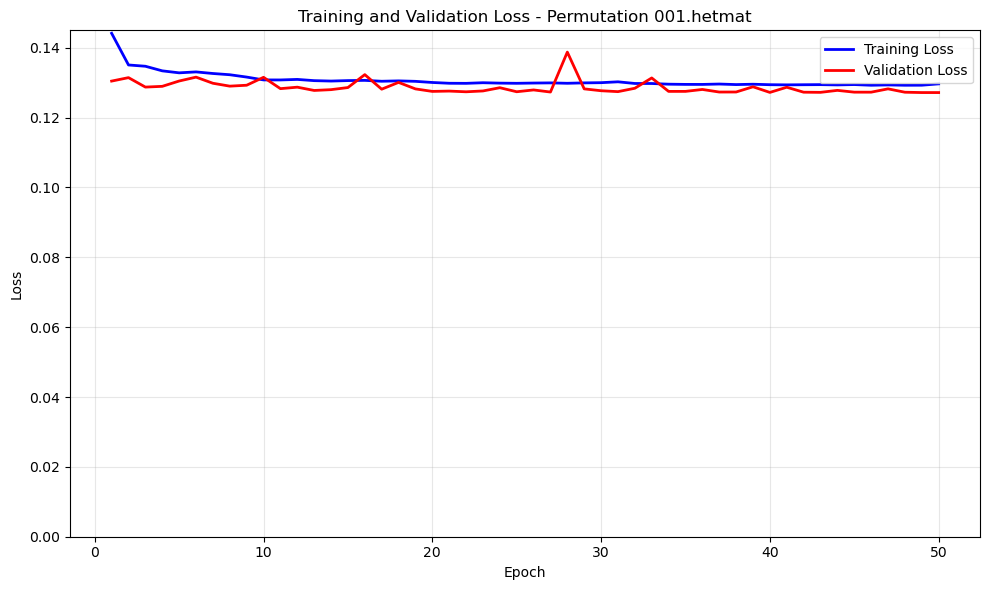

Training history plot saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/training_history_001.hetmat.png


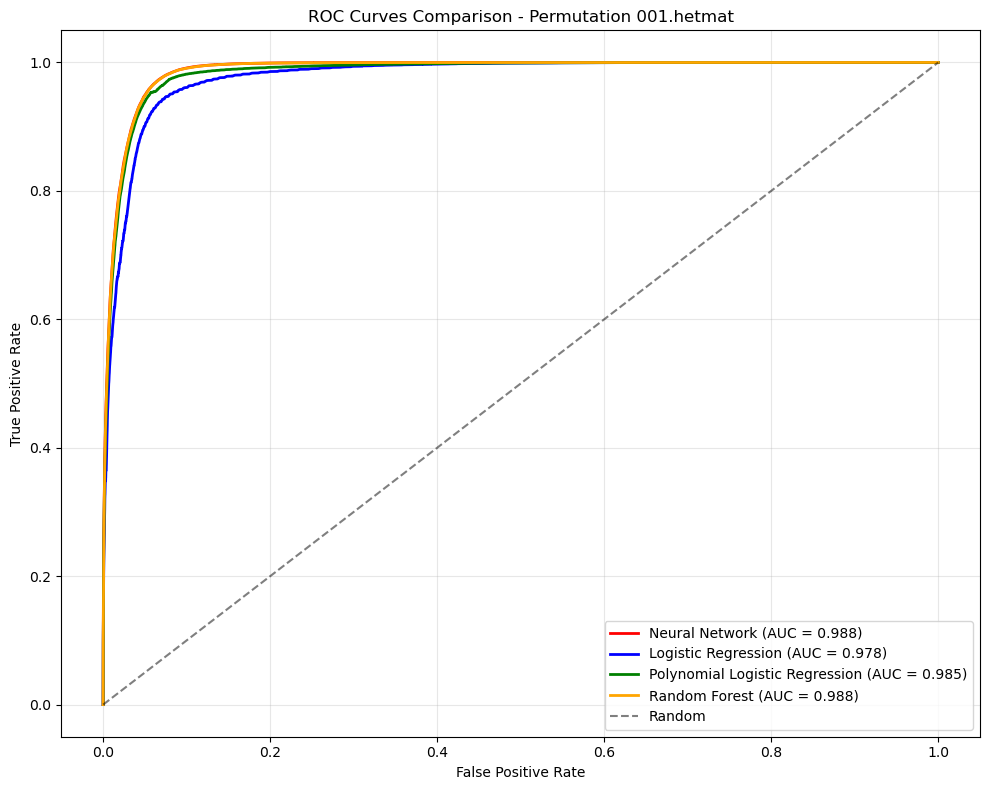

ROC comparison plot saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/roc_comparison_001.hetmat.png
Creating edge probability heatmaps for all models...


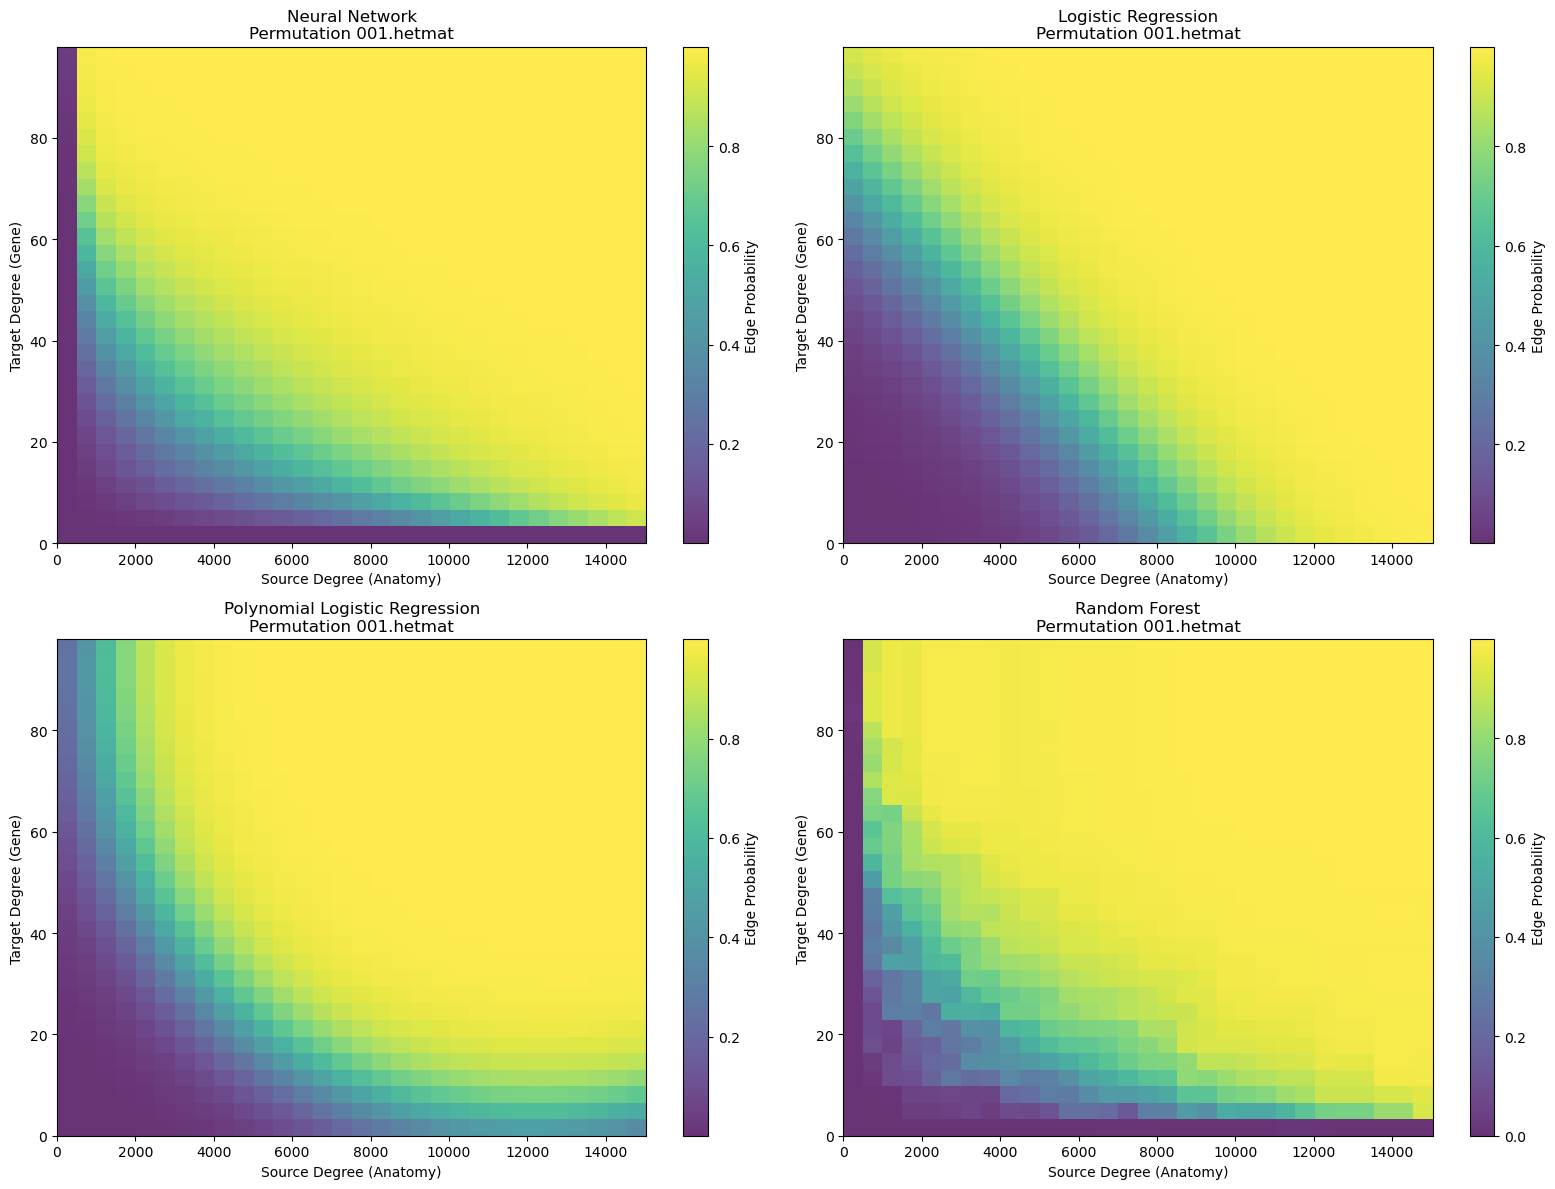

Probability heatmaps plot saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/probability_heatmaps_001.hetmat.png
Heatmap data saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/all_models_heatmaps_001.hetmat.npz

SAVING COMPREHENSIVE RESULTS FOR PERMUTATION 001.hetmat

Results for Permutation 001.hetmat:
Neural Network       - Test AUC: 0.9877, Test AP: 0.9851, Training time: 238.12s
Logistic Regression  - Test AUC: 0.9779, Test AP: 0.9749, Training time: 0.158s
Polynomial Logistic Regression - Test AUC: 0.9845, Test AP: 0.9822, Training time: 0.234s
Random Forest        - Test AUC: 0.9875, Test AP: 0.9848, Training time: 2.854s

Performance vs Best Baseline:
NN AUC improvement: +0.0002
NN AP improvement: +0.0003
Comprehensive comparison results saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofC

In [41]:
# Run complete edge prediction experiment using consolidated script
print("\n" + "=" * 60)
print("RUNNING EDGE PREDICTION EXPERIMENT VIA CONSOLIDATED SCRIPT")
print("=" * 60)

# Import and run the edge prediction runner
from run_edge_prediction import EdgePredictionRunner

# Create runner with current parameters
runner = EdgePredictionRunner(
    permutations_dir=permutations_dir,
    output_dir=output_models_dir,
    edge_type=edge_type,
    source_node_type=source_node_type,
    target_node_type=target_node_type
)

# Run complete experiment for the selected permutation
results = runner.run_experiment(
    permutation_name=selected_permutation,
    sample_negative_ratio=1.0
)

# Display final results summary
print(f"\n{'='*60}")
print("EXPERIMENT SUMMARY")
print(f"{'='*60}")
print(f"Permutation: {selected_permutation}")
print(f"Edge Type: {edge_type} ({source_node_type} -> {target_node_type})")
print(f"Neural Network AUC: {results['neural_network']['test_auc']:.4f}")
print(f"Neural Network AP: {results['neural_network']['test_ap']:.4f}")
print(f"Best baseline AUC: {results['performance_summary']['best_auc']:.4f}")
print(f"NN improvement over baseline: {results['performance_summary']['nn_vs_best_baseline_auc']:+.4f}")
print(f"All results saved to: {output_models_dir}")
print(f"{'='*60}")

# Store key results in notebook variables for backwards compatibility
test_metrics = {
    'auc': results['neural_network']['test_auc'],
    'average_precision': results['neural_network']['test_ap']
}

training_times = results['training_times']
nn_training_time = results['neural_network']['training_time_seconds']

print(f"\nAll function calls successfully moved to src/run_edge_prediction.py")
print(f"Notebook now uses consolidated script approach for better maintainability")

In [46]:
# Comprehensive model visualization is now handled by the consolidated script
print("\n" + "=" * 60)
print("COMPREHENSIVE MODEL VISUALIZATION")
print("=" * 60)

print("All comprehensive visualizations have been created by the edge prediction script.")
print("This includes:")
print("  - ROC curves comparison for all models")
print("  - Side-by-side probability heatmaps")
print("  - Training history plots")
print("  - Model correlation analysis")

print("\nVisualization files saved:")
print(f"  - Training history: {output_models_dir}/training_history_{selected_permutation}.png")
print(f"  - ROC comparison: {output_models_dir}/roc_comparison_{selected_permutation}.png")
print(f"  - Probability heatmaps: {output_models_dir}/probability_heatmaps_{selected_permutation}.png")

print(f"\nData files saved:")
print(f"  - Heatmap data: {output_models_dir}/all_models_heatmaps_{selected_permutation}.npz")
print(f"  - Model comparison: {output_models_dir}/comprehensive_model_comparison_{selected_permutation}.json")

# Display summary if results available
if 'results' in locals():
    print(f"\nExperiment completed successfully!")
    print(f"Best performing model: Neural Network (AUC: {results['neural_network']['test_auc']:.4f})")
    print(f"Improvement over best baseline: {results['performance_summary']['nn_vs_best_baseline_auc']:+.4f} AUC")

print("\nAll visualization and analysis functions have been consolidated into src/run_edge_prediction.py")
print("This provides better code organization, reusability, and maintainability.")


COMPREHENSIVE MODEL VISUALIZATION
All comprehensive visualizations have been created by the edge prediction script.
This includes:
  - ROC curves comparison for all models
  - Side-by-side probability heatmaps
  - Training history plots
  - Model correlation analysis

Visualization files saved:
  - Training history: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/training_history_001.hetmat.png
  - ROC comparison: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/roc_comparison_001.hetmat.png
  - Probability heatmaps: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models/probability_heatmaps_001.hetmat.png

Data files saved:
  - Heatmap data: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability